In [1]:
import os
import torch
import botorch # library for Bayesian Optimisation research
import gpytorch
torch.set_default_dtype(torch.double)

SMOKE_TEST = os.environ.get("SMOKE_TEST")

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f'Running on PyTorch {torch.__version__}, Botorch {botorch.__version__}, using {device} device')

Running on PyTorch 1.12.1, Botorch 0.8.1, using cpu device


In [205]:
print(f'Running on gpytorch {gpytorch.__version__}')
print(f'Running on numpy {np.__version__}')
import sklearn, scipy, matplotlib,pyDOE
print(f'Running on sklearn {sklearn.__version__}')
print(f'Running on scipy {scipy.__version__}')
print(f'Running on matplotlib {matplotlib.__version__}')
print(f'Running on pandas {pd.__version__}')
print(f'Running on pydoe {pyDOE.__version__}')

Running on gpytorch 1.9.1
Running on numpy 1.22.0
Running on sklearn 1.2.1
Running on scipy 1.10.0
Running on matplotlib 3.4.2
Running on pandas 1.5.3
Running on pydoe 0.3.8


### Problem setup

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from MinMaxScaler import inverse_transform
data = 'Case3_finer.csv'
# Data loading
def load_data(data=data):
    df = pd.read_csv(data)
    X_data  = np.vstack([df["alpha0"].to_numpy() ,
                df["alpha1"].to_numpy() ,
                df["alpha2"].to_numpy() ,
                df["alpha3"].to_numpy() ])
    pts = X_data.T.copy()
    pts = StandardScaler().fit_transform(pts)
    '''COMPUTE DIFFERENT CASES AND PLOT THEM'''
    #Cx_data = df['SumCx'].to_numpy() 
    Cx_data = np.vstack([df['SumCx'].to_numpy() ,
                         df['SumCy'].to_numpy() ])

    #obs = Cx_data.reshape(-1,1).copy()
    obs = Cx_data.T.copy() 
    obs = StandardScaler().fit_transform(obs)
    return pts, obs

In [3]:
from sklearn.decomposition import PCA
   
# Compute PCA 
def PCA_transformation(pts_original):
    pca = PCA(n_components=4, svd_solver='full').fit(pts_original)
    pts_transformed = pca.transform(pts_original)
    return pts_transformed

In [4]:
from pyDOE import lhs
from scipy.interpolate import NearestNDInterpolator

# Sample RSMs
def data_resample(pts, obs):
    dim = pts.shape[1]
    N = 10000
    lb = np.min( pts,axis=0)
    ub = np.max( pts,axis=0)
    bounds = {'lb': lb, 'ub': ub}
    # Generate latin-hypercube
    new_pts = lb + (ub - lb) * lhs(dim, N) 
    # pts are not in convex hull of pts (LD interpolator does not extrapolate) 
    r =  NearestNDInterpolator( pts, obs)
    # pts has to be inside region of interpolation .
    valuesTrasf = r(new_pts) 
    #valuesTrasf.reshape(-1,1).T
    return new_pts,valuesTrasf

In [5]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

pts, obs = load_data()
pts = PCA_transformation(pts)
new_pts,new_obs = data_resample(pts, obs)

class TestcaseDataset(Dataset):
    def __init__(self,new_pts,new_obs,dim):
        data = np.hstack([new_pts,new_obs]) 
        hifi, lofi = train_test_split(data, test_size=1e-3, shuffle=True)
        hifi, test = train_test_split(hifi, test_size=1e-1)
        size=dim-data.shape[1]
        # Cast them
        self.X_hifi = torch.Tensor(hifi[:,:size]) 
        self.X_lofi = torch.Tensor(lofi[:,:size]) 
        self.X_test = torch.Tensor(test[:,:size]) 
        self.Y_hifi = torch.Tensor(hifi[:,size:])#.unsqueeze(-1)
        self.Y_lofi = torch.Tensor(lofi[:,size:])#.unsqueeze(-1)
        self.Y_test = torch.Tensor(test[:,size:])#.unsqueeze(-1)

        self.hifi_dataset = TensorDataset(self.X_hifi, self.Y_hifi)
        self.test_dataset = TensorDataset(self.X_test, self.Y_test)
    def __call__(self):
        return (self.hifi_dataset, 
                self.test_dataset, 
                self.X_hifi, 
                self.X_lofi, 
                self.X_test, 
                self.Y_hifi, 
                self.Y_lofi, 
                self.Y_test, 

                )

In [6]:
from botorch.models.transforms.outcome import Standardize
from botorch.utils.transforms import unnormalize, normalize
#bounds = torch.stack([-2.5 * torch.ones(pts.shape[-1]), 2.5 * torch.ones(pts.shape[-1])])
dataset = TestcaseDataset(new_pts,new_obs,pts.shape[1])

X_lofi = dataset.X_lofi#normalize(dataset.X_lofi,bounds=bounds)
X_hifi = dataset.X_hifi#normalize(dataset.X_hifi,bounds=bounds)
X_test = dataset.X_test#normalize(dataset.X_test,bounds=bounds)
Y_lofi = dataset.Y_lofi
Y_hifi = dataset.Y_hifi
Y_test = dataset.Y_test

hifi_dataset = dataset.hifi_dataset
test_dataset = dataset.test_dataset

print("Shape of low fidelity  X and y: ",X_lofi.shape, Y_lofi.shape)
print("Shape of high fidelity X and y: ",X_hifi.shape, Y_hifi.shape)
print("Shape of test set      X and y: ",X_test.shape, Y_test.shape)
bounds = torch.Tensor([[pts[:,0].min(), pts[:,1].min(), pts[:,2].min(), pts[:,3].min()], [pts[:,0].max(), pts[:,1].max(), pts[:,2].max(), pts[:,3].max()]])
print("Buonds shape: ", bounds.shape)

# Create data loaders
hifi_dataloader = DataLoader(hifi_dataset, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=True)
best_obs_value = Y_hifi.numpy().max()

noise_level = 1e-1
noise = noise_level*torch.ones(X_lofi.shape[0])

print('pts shape',pts.shape)

Shape of low fidelity  X and y:  torch.Size([10, 4]) torch.Size([10, 2])
Shape of high fidelity X and y:  torch.Size([8991, 4]) torch.Size([8991, 2])
Shape of test set      X and y:  torch.Size([999, 4]) torch.Size([999, 2])
Buonds shape:  torch.Size([2, 4])
pts shape (1292, 4)


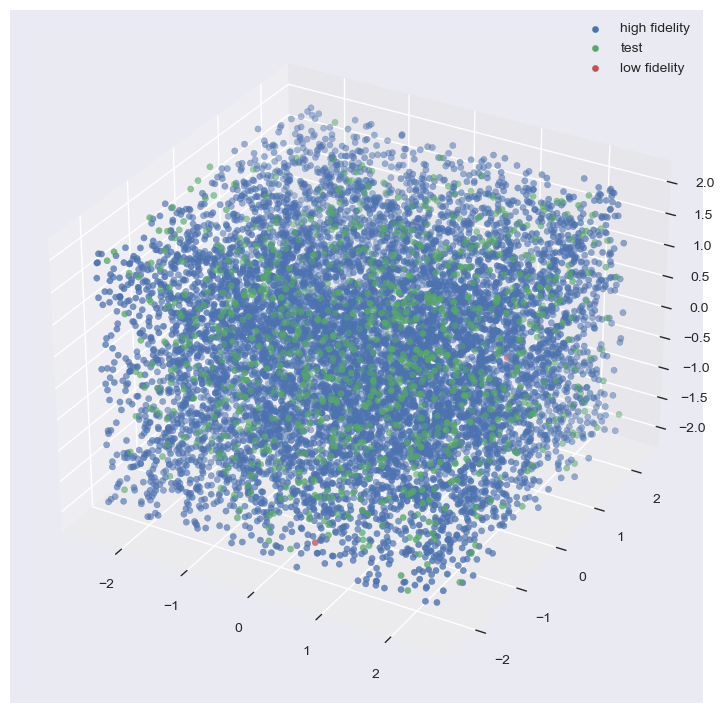

In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig = plt.figure(figsize=(21, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_hifi[:, 0],X_hifi[:, 1],X_hifi[:, 2],label = 'high fidelity')
ax.scatter(X_test[:, 0],X_test[:, 1],X_test[:, 2],label = 'test')
ax.scatter(X_lofi[:, 0],X_lofi[:, 1],X_lofi[:, 2],label = 'low fidelity')
plt.legend()
plt.show()


### High Fidelity Model initilization

In [8]:
from torch import nn # Neural Network Module
# Define hyperparameters
n_samples, n_features = X_hifi.shape
input_size = n_features
hidden_size = 128
output_size = Y_hifi.shape[1]
learning_rate = 1e-2
# Define the neural network model (input, hidden, output size)
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(NeuralNet, self).__init__()
        # Define layers
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU() # activation function nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        #out = self.sigmoid(out)
        return out

In [9]:

nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
print(nn_model)

''' Construct loss and optmizer '''
criterion = nn.MSELoss() # Mean Square Error Loss # loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate) # from the optimization module

''' In a single training epoch, the model makes predictions on the training dataset (fed to it in batches)
and backpropagates the prediction error to update the model’s parameters '''

# Training loop:
#  - forward pass: compute predictions
#  - backward pass: gradients
#  - update weights
NUM_EPOCHS = 1000 if not SMOKE_TEST else 5 # epoch -> forward and backward of ALL training samples
for epoch in range(NUM_EPOCHS):
    size = len(hifi_dataloader.dataset)
    nn_model.train()
    for batch, (X, y) in enumerate(hifi_dataloader):
        X, y = X.to(device), y.to(device)

        ''' Compute prediction error '''
        pred = nn_model(X)         # prediction: forward pass
        loss = criterion(pred, y) # loss

        ''' Backpropagation '''
        optimizer.zero_grad()   # clears old gradients from the last step
        loss.backward()         # gradients: backward pass
        optimizer.step()        # update weights

    if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} / {NUM_EPOCHS}, step [{batch+1}/{len(hifi_dataloader)}] loss: {loss:.4f}")

''' SAVE THE NEURAL NETWORK MODEL'''
cwd = os.getcwd()
model_file = "testcase_nn_model_state.pt"
torch.save(nn_model.state_dict(), os.path.join(cwd, model_file))

''' Test '''    
nn_model.eval()
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss, correct, num_samples = 0, 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = nn_model(X)
        test_loss += criterion(pred, y).item()
        #num_samples += y.shape[0]
        #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
#correct /= size
#acc = 100.0 * correct / num_samples
print(f"Test Error -> Test loss: {test_loss:>8f} \n") # Acc: {acc:>8f}

NeuralNet(
  (linear1): Linear(in_features=4, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=128, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 10 / 88000, step [281/281] loss: 0.1689
Epoch 20 / 88000, step [281/281] loss: 0.2704
Epoch 30 / 88000, step [281/281] loss: 0.2025
Epoch 40 / 88000, step [281/281] loss: 0.1097
Epoch 50 / 88000, step [281/281] loss: 0.2053
Epoch 60 / 88000, step [281/281] loss: 0.1258
Epoch 70 / 88000, step [281/281] loss: 0.1854
Epoch 80 / 88000, step [281/281] loss: 0.0665
Epoch 90 / 88000, step [281/281] loss: 0.1570
Epoch 100 / 88000, step [281/281] loss: 0.2639
Epoch 110 / 88000, step [281/281] loss: 0.3380
Epoch 120 / 88000, step [281/281] loss: 0.1848
Epoch 130 / 88000, step [281/281] loss: 0.1390
Epoch 140 / 88000, step [281/281] loss: 0.1455
Epoch 150 / 88000, step [281/281] loss: 0.0852
Epoch 160 / 88000, step [281/281] loss: 0.1743
Epoch 170 / 88000, step [281/281] loss: 0.1163
Epoch

In [ ]:
# Import model saved
nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
nn_model.load_state_dict(torch.load(os.path.join(os.getcwd(), "testcase_nn_model_state_noPCA_3000_dualobj.pt")))
nn_model.eval()

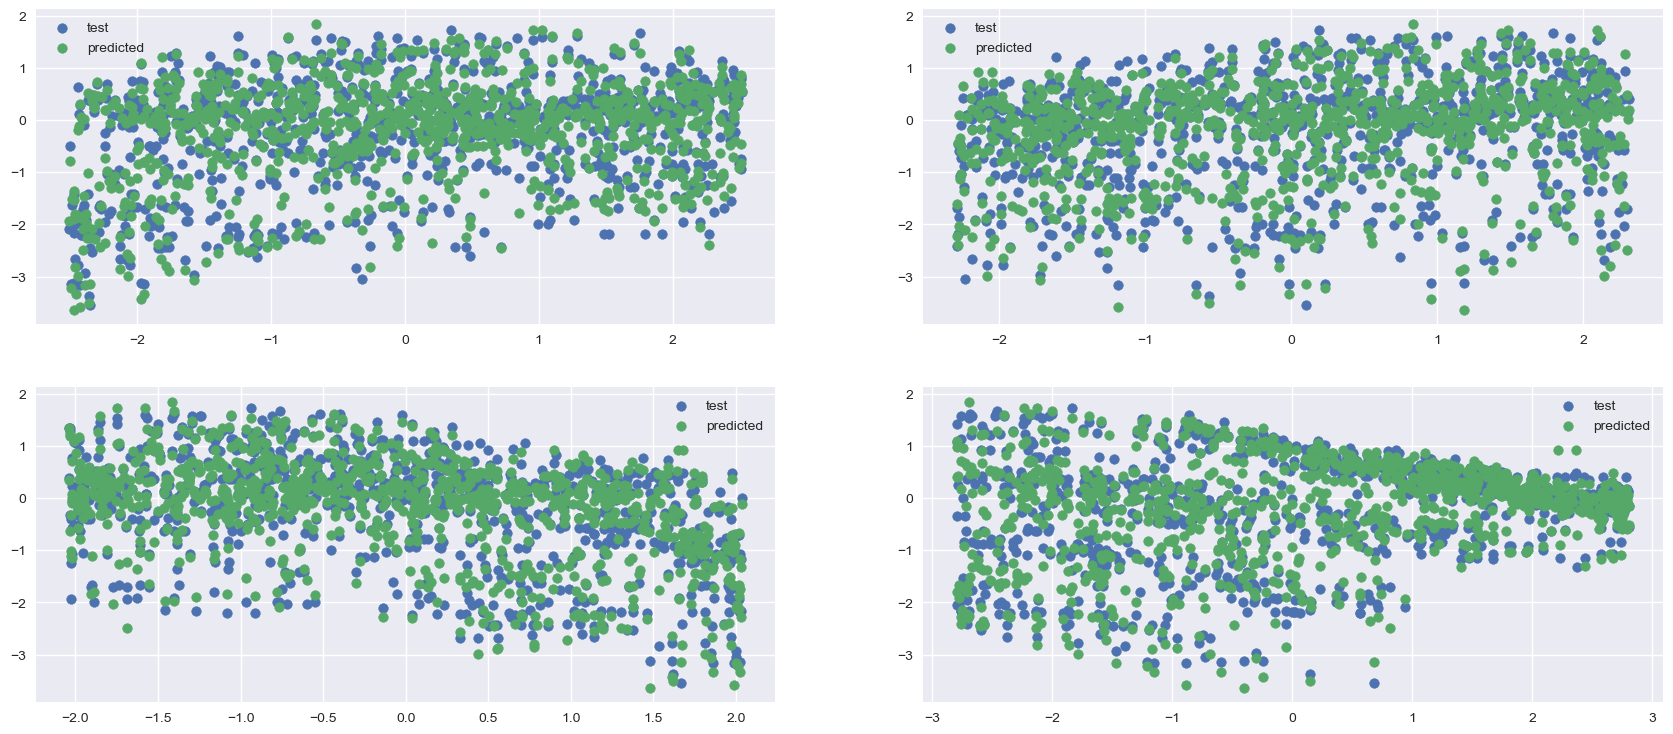

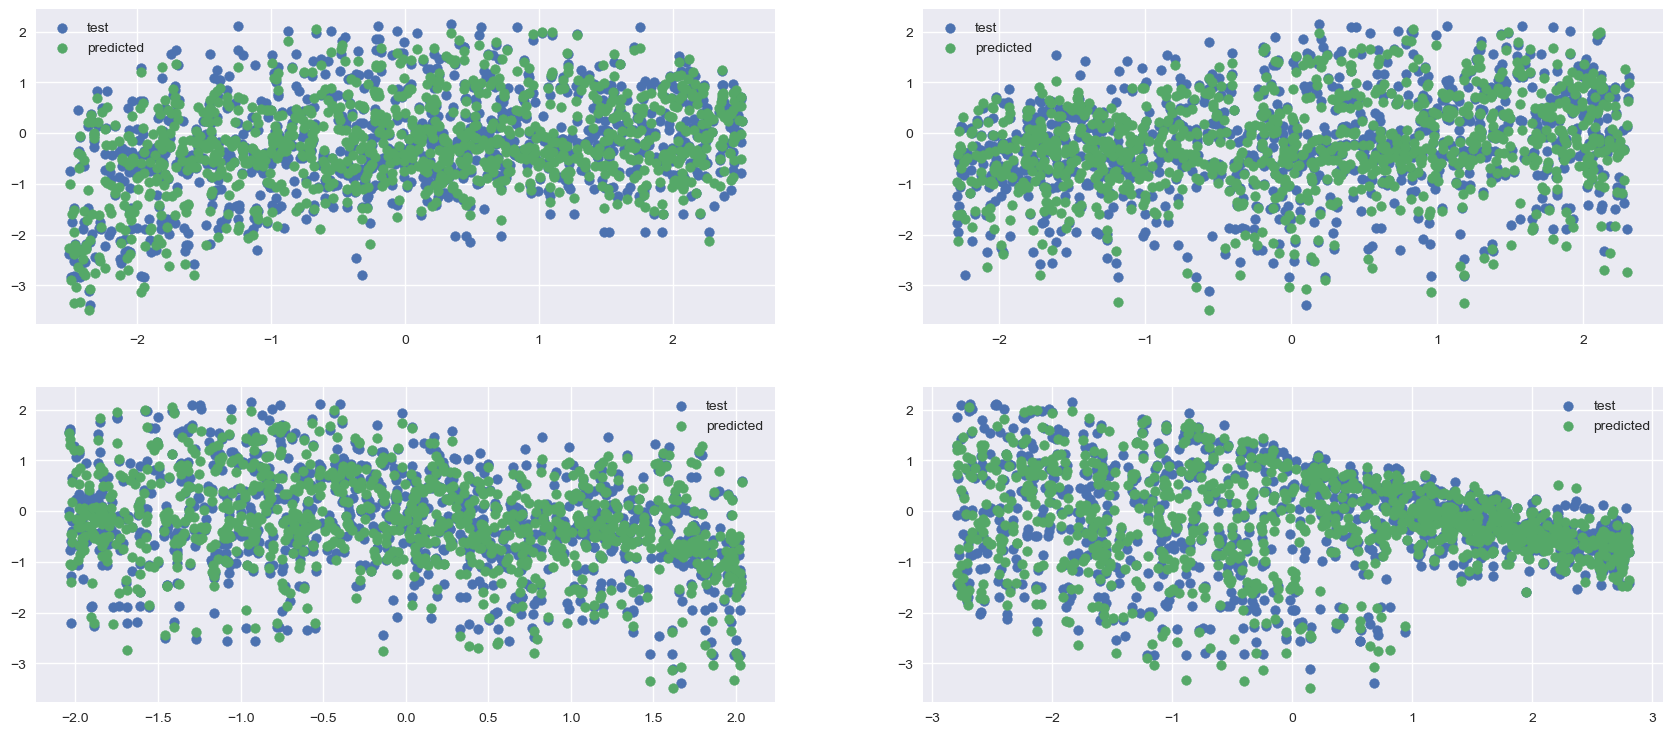

In [10]:
# Visualize the neural network prediction vs the test data
with torch.no_grad():
    Y_pred = nn_model(X_test)

for i in range(Y_test.shape[-1]):
    fig = plt.figure(figsize=(21, 9))
    for alpha in range(X_test.shape[-1]):
        ax = fig.add_subplot(2, 2, alpha+1)
        ax.scatter(X_test[:,alpha].numpy(), Y_test[:,i].numpy(),label = 'test')
        ax.scatter(X_test[:,alpha].numpy(), Y_pred[:,i].numpy(),label = 'predicted')
        plt.legend()


### Surrogate Model Initialization

In [12]:
from botorch.models import SingleTaskGP, FixedNoiseGP, ModelListGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

def initialize_model(X, Y, noise, state_dict=None):
  train_x, train_obj = X.to(device), Y.to(device)
  models = []

  likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=noise)#, learn_additional_noise=False)
  
  for i in range(train_obj.shape[-1]):
      train_y = train_obj[..., i : i + 1]
      models.append(
          SingleTaskGP(
              train_x, train_y
          )
      )
  model = ModelListGP(*models)
  mll = SumMarginalLogLikelihood(model.likelihood, model)

  #mll = ExactMarginalLogLikelihood(likelihood, single_model) # OTHER LIKELIHOOD ?
  ''' load state dict if it is passed '''
  if state_dict is not None:
    model.load_state_dict(state_dict)
  return mll, model

Define a helper function that performs the essential BO step

In [13]:
from botorch.optim import optimize_acqf
from botorch.utils.sampling import manual_seed

NUM_POINTS = 1 if not SMOKE_TEST else 1
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32
NUM_INITIAL_POINTS = X_lofi.shape[0]

def opt_acq_and_get_next_obj(acqf):
  """Optimizes the acquisition function, and returns a new candidate."""
  with manual_seed(1234):
    candidates, acq_value = optimize_acqf(
        acq_function=acqf, 
        bounds=bounds,
        q=NUM_POINTS,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={"batch_limit": 10, "maxiter": 200},
    )
  ''' get a new obj '''
  with torch.no_grad():
    predicted_optimal_obj = nn_model(candidates)
  return candidates, predicted_optimal_obj

### Perform a few steps of multi-fidelity BO

In [16]:
from botorch.acquisition import (UpperConfidenceBound,
                                 ProbabilityOfImprovement,
                                 NoisyExpectedImprovement,
                                 ExpectedImprovement,
                                 qKnowledgeGradient,
                                 PosteriorMean)
from botorch.acquisition.monte_carlo import (qExpectedImprovement, 
                                             qNoisyExpectedImprovement)
from botorch.acquisition.objective import ScalarizedPosteriorTransform

from botorch.fit import fit_gpytorch_mll
from botorch.sampling import SobolQMCNormalSampler

N_ITER = 64 if not SMOKE_TEST else 1 # hp: not enough NUM_EPOCHS or training the nn model led to NumericalWarning in high N_ITER
NUM_FANTASIES = 128 if not SMOKE_TEST else 4
MC_SAMPLES = 256 if not SMOKE_TEST else 32

X_lofi = X_lofi[0:NUM_INITIAL_POINTS]
Y_lofi = Y_lofi[0:NUM_INITIAL_POINTS]
''' ITERATE UNTIL CONVERGE ON ACCURACY TEST WITH TEST DATA (NN)'''

X_lofi_UCB,  Y_lofi_UCB  = X_lofi, Y_lofi
X_lofi_PI,   Y_lofi_PI   = X_lofi, Y_lofi
X_lofi_EI,   Y_lofi_EI   = X_lofi, Y_lofi
X_lofi_qEI,  Y_lofi_qEI  = X_lofi, Y_lofi
X_lofi_qNEI, Y_lofi_qNEI = X_lofi, Y_lofi
'''X_lofi_qKG,  qKG_Y_lofi  = X_lofi, Y_lofi
X_lofi_qKGp, qKGp_Y_lofi = X_lofi, Y_lofi'''

mll,      gp_model      = initialize_model(X_lofi,      Y_lofi,      noise)
mll_UCB,  gp_model_UCB  = initialize_model(X_lofi_UCB,  Y_lofi_UCB,  noise)
mll_PI,   gp_model_PI   = initialize_model(X_lofi_PI,   Y_lofi_PI,   noise)
mll_EI,   gp_model_EI   = initialize_model(X_lofi_EI,   Y_lofi_EI,   noise)
mll_qEI,  gp_model_qEI  = initialize_model(X_lofi_qEI,  Y_lofi_qEI,  noise)
mll_qNEI, gp_model_qNEI = initialize_model(X_lofi_qNEI, Y_lofi_qNEI, noise)
'''mll_qKG,  gp_model_qKG  = initialize_model(X_lofi,  Y_lofi,  noise)
mll_qKGp, gp_model_qKGp = initialize_model(X_lofi, Y_lofi, noise)'''

for iter in range(N_ITER):

     ''' fit the models '''
     fit_gpytorch_mll(mll)
     fit_gpytorch_mll(mll_UCB)
     fit_gpytorch_mll(mll_PI)
     fit_gpytorch_mll(mll_EI)
     fit_gpytorch_mll(mll_qEI)
     fit_gpytorch_mll(mll_qNEI)

     ''' define the qEI and qNEI acquisition modules using a QMC sampler '''
     sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
     
     pt = ScalarizedPosteriorTransform(weights=torch.tensor([0.5, 0.5]))

     ''' for best_f, we use the best observed noisy values as an approximation '''
     UCB  = UpperConfidenceBound(
          model = gp_model_UCB, 
          beta=0.3,
          posterior_transform=pt,
     )
     PI  = ProbabilityOfImprovement( 
          model = gp_model_PI, 
          best_f = Y_lofi_PI.max(),
          posterior_transform=pt,
          )
     EI  = ExpectedImprovement( 
          model = gp_model_EI, 
          best_f = Y_lofi_EI.max() ,
          posterior_transform=pt,
     )
     qEI  = qExpectedImprovement( 
          model = gp_model_qEI, 
          best_f = Y_lofi_qEI.max(), 
          sampler=sampler,
          posterior_transform=pt,
     )
     qNEI  = qNoisyExpectedImprovement(
          model = gp_model_qNEI, 
          X_baseline = X_lofi_qNEI, 
          sampler=sampler,
          posterior_transform=pt,
     )
     '''qKG  = qKnowledgeGradient(
          model = gp_model_qKG, 
          num_fantasies=NUM_FANTASIES
     )
     qKG_proper  = qKnowledgeGradient(
          model = gp_model_qKGp, 
          num_fantasies=NUM_FANTASIES
     )
     argmax_pmean, max_pmean = optimize_acqf(
      acq_function=PosteriorMean(single_model), 
      bounds=bounds,
      q=NUM_POINTS,
      num_restarts=10 if not SMOKE_TEST else 2,
      raw_samples=1024 if not SMOKE_TEST else 4,
     )
     acqf_name = qKnowledgeGradient(
      single_model,
      num_fantasies=NUM_FANTASIES,
      sampler=qKG.sampler,
      current_value=max_pmean,
    )'''
     ''' optimize and get new observation '''
     new_X_UCB,  predicted_optimal_obj_UCB  = opt_acq_and_get_next_obj(UCB)  
     new_X_PI,   predicted_optimal_obj_PI   = opt_acq_and_get_next_obj(PI)  
     new_X_EI,   predicted_optimal_obj_EI   = opt_acq_and_get_next_obj(EI)  
     new_X_qEI,  predicted_optimal_obj_qEI  = opt_acq_and_get_next_obj(qEI)  
     new_X_qNEI, predicted_optimal_obj_qNEI = opt_acq_and_get_next_obj(qNEI)  
     new_X = torch.randn_like(new_X_qNEI)
     with torch.no_grad():
          predicted_obj = nn_model(new_X) + .1 * torch.randn(1)

     print(f"Iter {iter+1}/{N_ITER}")# - next points: {new_X}\n pred objectives: {predicted_optimal_obj}")

     ''' update training points '''
     X_lofi      = torch.cat([X_lofi,      new_X ])
     X_lofi_UCB  = torch.cat([X_lofi_UCB,  new_X_UCB ])
     X_lofi_PI   = torch.cat([X_lofi_PI,   new_X_PI ])
     X_lofi_EI   = torch.cat([X_lofi_EI,   new_X_EI ])
     X_lofi_qEI  = torch.cat([X_lofi_qEI,  new_X_qEI ])
     X_lofi_qNEI = torch.cat([X_lofi_qNEI, new_X_qNEI ])

     Y_lofi      = torch.cat([Y_lofi,      predicted_obj])
     Y_lofi_UCB  = torch.cat([Y_lofi_UCB,  predicted_optimal_obj_UCB])
     Y_lofi_PI   = torch.cat([Y_lofi_PI,   predicted_optimal_obj_PI])
     Y_lofi_EI   = torch.cat([Y_lofi_EI,   predicted_optimal_obj_EI])
     Y_lofi_qEI  = torch.cat([Y_lofi_qEI,  predicted_optimal_obj_qEI])
     Y_lofi_qNEI = torch.cat([Y_lofi_qNEI, predicted_optimal_obj_qNEI])

     '''best_obs_value = max(best_obs_value,Y_lofi.max())
     best_obs_value = max(best_obs_value,Y_lofi.max())
     best_obs_value = max(best_obs_value,Y_lofi.max())
     best_obs_value = max(best_obs_value,Y_lofi.max())
     best_obs_value = max(best_obs_value,Y_lofi.max())
     best_obs_value = max(best_obs_value,Y_lofi.max())'''

     noise  = torch.cat([noise, 1e-3*torch.ones(new_X.shape[0]) ])

     mll,      gp_model      = initialize_model(X_lofi,      Y_lofi,      noise, gp_model.state_dict())
     mll_UCB,  gp_model_UCB  = initialize_model(X_lofi_UCB,  Y_lofi_UCB,  noise, gp_model_UCB.state_dict())
     mll_PI,   gp_model_PI   = initialize_model(X_lofi_PI,   Y_lofi_PI,   noise, gp_model_PI.state_dict())
     mll_EI,   gp_model_EI   = initialize_model(X_lofi_EI,   Y_lofi_EI,   noise, gp_model_EI.state_dict())
     mll_qEI,  gp_model_qEI  = initialize_model(X_lofi_qEI,  Y_lofi_qEI,  noise, gp_model_qEI.state_dict())
     mll_qNEI, gp_model_qNEI = initialize_model(X_lofi_qNEI, Y_lofi_qNEI, noise, gp_model_qNEI.state_dict())
     '''mll_qKG,  gp_model_qKG  = initialize_model(qKG_X_lofi,  qKG_Y_lofi,  noise)
     mll_qKGp, gp_model_qKGp = initialize_model(qKGp_X_lofi, qKGp_Y_lofi, noise)'''

Iter 1/64
Iter 2/64
Iter 3/64
Iter 4/64
Iter 5/64
Iter 6/64
Iter 7/64
Iter 8/64
Iter 9/64
Iter 10/64
Iter 11/64
Iter 12/64
Iter 13/64
Iter 14/64
Iter 15/64
Iter 16/64
Iter 17/64
Iter 18/64
Iter 19/64
Iter 20/64
Iter 21/64
Iter 22/64
Iter 23/64
Iter 24/64
Iter 25/64
Iter 26/64
Iter 27/64
Iter 28/64
Iter 29/64
Iter 30/64
Iter 31/64
Iter 32/64
Iter 33/64
Iter 34/64
Iter 35/64
Iter 36/64
Iter 37/64
Iter 38/64
Iter 39/64
Iter 40/64
Iter 41/64
Iter 42/64
Iter 43/64
Iter 44/64
Iter 45/64
Iter 46/64
Iter 47/64
Iter 48/64
Iter 49/64
Iter 50/64
Iter 51/64
Iter 52/64
Iter 53/64
Iter 54/64
Iter 55/64
Iter 56/64
Iter 57/64
Iter 58/64
Iter 59/64
Iter 60/64
Iter 61/64


c:\Users\Utente\mambaforge\envs\advpy\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 62/64
Iter 63/64


c:\Users\Utente\mambaforge\envs\advpy\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 64/64


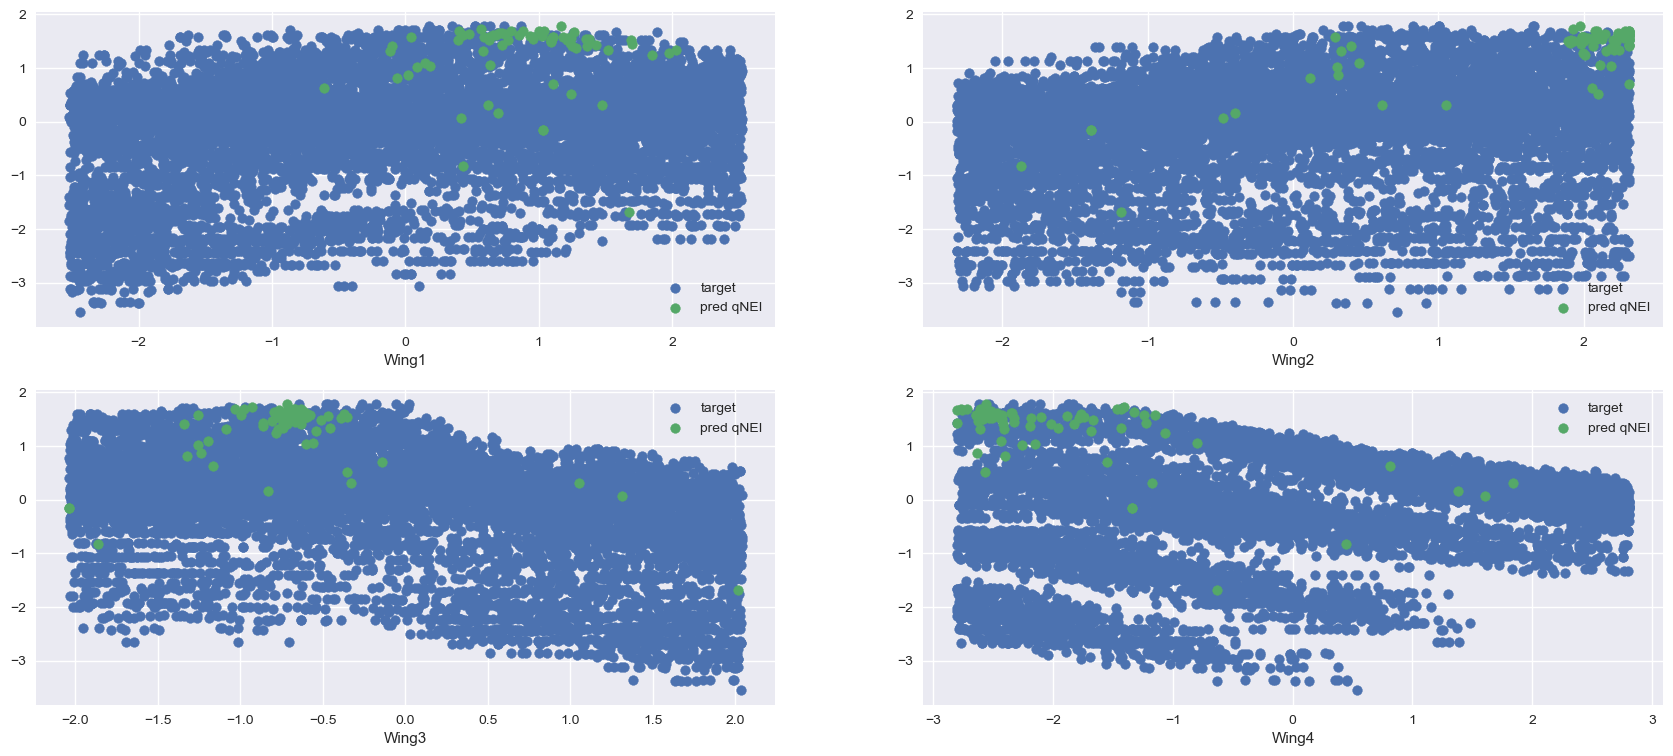

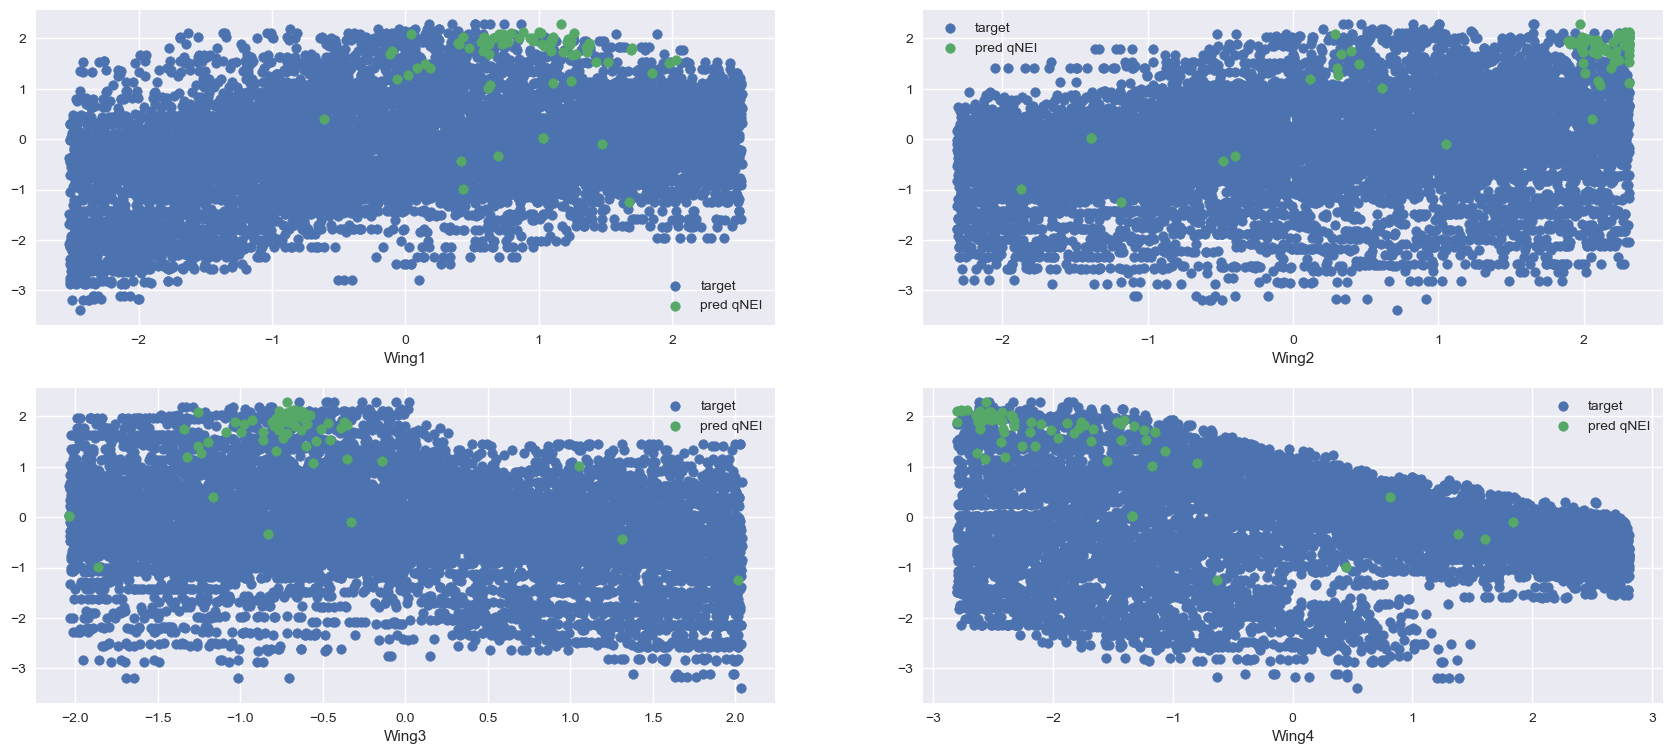

In [25]:
for i in range(Y_lofi.shape[-1]):
    fig = plt.figure(figsize=(21, 9))
    for alpha in range(X_lofi.shape[-1]):
        ax = fig.add_subplot(2, 2, alpha+1)
        ax.scatter(X_hifi[:,alpha].numpy(), Y_hifi[:,i].numpy(),label = 'target')
        #ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi[:,i].numpy(),label = 'predicted')
        #ax.scatter(X_lofi_UCB[:,alpha].numpy(), Y_lofi_UCB[:,i].numpy(),label = 'pred UCB')
        #ax.scatter(X_lofi_PI[ :,alpha].numpy(), Y_lofi_PI[ :,i].numpy(),label = 'pred PI')
        #ax.scatter(X_lofi_EI[ :,alpha].numpy(), Y_lofi_EI[ :,i].numpy(),label = 'pred EI')
        #ax.scatter(X_lofi_qEI[:,alpha].numpy(), Y_lofi_qEI[:,i].numpy(),label = 'pred qEI')
        ax.scatter(X_lofi_qNEI[:,alpha].numpy(), Y_lofi_qNEI[:,i].numpy(),label = 'pred qNEI')
        plt.legend()
        plt.xlabel(f"Wing{alpha+1}")
plt.show() 

In [45]:
# Define the Kernel of Gaussian Process
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,X_train, Y_train, likelihood=gpytorch.likelihoods.GaussianLikelihood()):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

In [122]:
#del gp_model, gp_model_UCB, gp_model_PI, gp_model_EI, gp_model_qEI, gp_model_qNEI

for alpha in range(2):#X_lofi.shape[-1]):
    ''' Fit the model '''
 
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_UCB = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_PI = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_EI = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_qEI = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_qNEI = gpytorch.likelihoods.GaussianLikelihood()

    train_multi_yvar = noise**2*torch.ones(X_lofi[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1).shape[0],1, device=device)

    ''' Define the model '''
    #gp_model      = FixedNoiseGP(X_lofi[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),      Y_lofi[NUM_INITIAL_POINTS:],      train_multi_yvar)
    #gp_model_UCB  = FixedNoiseGP(X_lofi_UCB[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),  Y_lofi_UCB[NUM_INITIAL_POINTS:],  train_multi_yvar)
    #gp_model_PI   = FixedNoiseGP(X_lofi_PI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),   Y_lofi_PI[NUM_INITIAL_POINTS:],   train_multi_yvar)
    #gp_model_EI   = FixedNoiseGP(X_lofi_EI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),   Y_lofi_EI[NUM_INITIAL_POINTS:],   train_multi_yvar)
    #gp_model_qEI  = FixedNoiseGP(X_lofi_qEI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),  Y_lofi_qEI[NUM_INITIAL_POINTS:],  train_multi_yvar)
    #gp_model_qNEI = FixedNoiseGP(X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1), Y_lofi_qNEI[NUM_INITIAL_POINTS:], train_multi_yvar)

    #gp_model       = SingleTaskGP(X_lofi[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),      Y_lofi[NUM_INITIAL_POINTS:],      likelihood = likelihood  )
    #gp_model_UCB   = SingleTaskGP(X_lofi_UCB[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),  Y_lofi_UCB[NUM_INITIAL_POINTS:],  likelihood = likelihood_UCB  )
    #gp_model_PI    = SingleTaskGP(X_lofi_PI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),   Y_lofi_PI[NUM_INITIAL_POINTS:],   likelihood = likelihood_PI  )
    #gp_model_EI    = SingleTaskGP(X_lofi_EI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),   Y_lofi_EI[NUM_INITIAL_POINTS:],   likelihood = likelihood_EI  )
    #gp_model_qEI   = SingleTaskGP(X_lofi_qEI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),  Y_lofi_qEI[NUM_INITIAL_POINTS:],  likelihood = likelihood_qEI  )
    #gp_model_qNEI  = SingleTaskGP(X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1), Y_lofi_qNEI[NUM_INITIAL_POINTS:], likelihood = likelihood_qNEI  )

    gp_model      = ExactGPModel(X_lofi[NUM_INITIAL_POINTS:,alpha] ,      Y_lofi[NUM_INITIAL_POINTS:,0].squeeze(),      likelihood)
    gp_model_UCB  = ExactGPModel(X_lofi_UCB[NUM_INITIAL_POINTS:,alpha] ,  Y_lofi_UCB[NUM_INITIAL_POINTS:,0].squeeze(),  likelihood_UCB)
    gp_model_PI   = ExactGPModel(X_lofi_PI[NUM_INITIAL_POINTS:,alpha] ,   Y_lofi_PI[NUM_INITIAL_POINTS:,0].squeeze(),   likelihood_PI)
    gp_model_EI   = ExactGPModel(X_lofi_EI[NUM_INITIAL_POINTS:,alpha] ,   Y_lofi_EI[NUM_INITIAL_POINTS:,0].squeeze(),   likelihood_EI)
    gp_model_qEI  = ExactGPModel(X_lofi_qEI[NUM_INITIAL_POINTS:,alpha] ,  Y_lofi_qEI[NUM_INITIAL_POINTS:,0].squeeze(),  likelihood_qEI)
    gp_model_qNEI = ExactGPModel(X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha] , Y_lofi_qNEI[NUM_INITIAL_POINTS:,0].squeeze(), likelihood_qNEI)
    # Find optimal model hyperparameters
    gp_model.train()
    gp_model_UCB.train()
    gp_model_PI.train()
    gp_model_EI.train()
    gp_model_qEI.train()
    gp_model_qNEI.train()
    likelihood.train()
    likelihood_UCB.train()
    likelihood_PI.train()
    likelihood_EI.train()
    likelihood_qEI.train()
    likelihood_qNEI.train()
    # Use the adam optimizer  # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam(gp_model.parameters(),lr=1e-3) 
    optimizer_UCB = torch.optim.Adam(gp_model_UCB.parameters(),lr=1e-3)
    optimizer_PI = torch.optim.Adam(gp_model_PI.parameters(),lr=1e-3)
    optimizer_EI = torch.optim.Adam(gp_model_EI.parameters(),lr=1e-3)
    optimizer_qEI = torch.optim.Adam(gp_model_qEI.parameters(),lr=1e-3)
    optimizer_qNEI = torch.optim.Adam(gp_model_qNEI.parameters(),lr=1e-3)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model) 
    mll_UCB = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_UCB, gp_model_UCB)
    mll_PI = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_PI, gp_model_PI)
    mll_EI = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_EI, gp_model_EI)
    mll_qEI = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_qEI, gp_model_qEI)
    mll_qNEI = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_qNEI, gp_model_qNEI)
    #mll = gpytorch.mlls.LeaveOneOutPseudoLikelihood(likelihood, gp_model) # "Loss" for GPs - LOO Pseudo likelihood

    training_iter  = 1000 if not SMOKE_TEST else 4
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()    
        optimizer_UCB.zero_grad()
        optimizer_PI.zero_grad()
        optimizer_EI.zero_grad()
        optimizer_qEI.zero_grad()
        optimizer_qNEI.zero_grad()
        # Output from model
        output = gp_model(X_lofi[NUM_INITIAL_POINTS:,alpha])        
        output_UCB = gp_model_UCB(X_lofi_UCB[NUM_INITIAL_POINTS:,alpha])
        output_PI = gp_model_PI(X_lofi_PI[NUM_INITIAL_POINTS:,alpha])
        output_EI = gp_model_EI(X_lofi_EI[NUM_INITIAL_POINTS:,alpha])
        output_qEI = gp_model_qEI(X_lofi_qEI[NUM_INITIAL_POINTS:,alpha])
        output_qNEI = gp_model_qNEI(X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha])
        # compute loss and backprop gradients
        loss = -mll(output, Y_lofi[NUM_INITIAL_POINTS:,0].squeeze())
        loss_UCB = -mll_UCB(output_UCB, Y_lofi_UCB[NUM_INITIAL_POINTS:,0].squeeze())
        loss_PI = -mll_PI(output_PI, Y_lofi_PI[NUM_INITIAL_POINTS:,0].squeeze())
        loss_EI = -mll_EI(output_EI, Y_lofi_EI[NUM_INITIAL_POINTS:,0].squeeze())
        loss_qEI = -mll_qEI(output_qEI, Y_lofi_qEI[NUM_INITIAL_POINTS:,0].squeeze())
        loss_qNEI = -mll_qNEI(output_qNEI, Y_lofi_qNEI[NUM_INITIAL_POINTS:,0].squeeze())     
        loss.backward()
        loss_UCB.backward()
        loss_PI.backward()
        loss_EI.backward()
        loss_qEI.backward()
        loss_qNEI.backward()
        if (i+1) % 100 == 0:
            print(f'Wing{alpha+1} - Iter {i + 1}/{training_iter}')# - Loss: {loss.item():.5f} LenghtParam {gp_model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0]:.5f}')
        optimizer.step()
        optimizer_UCB.step()
        optimizer_PI.step()
        optimizer_EI.step()
        optimizer_qEI.step()
        optimizer_qNEI.step()
    print('\n')
    
    gp_model.eval()
    gp_model_UCB.eval()
    gp_model_PI.eval()
    gp_model_EI.eval()
    gp_model_qEI.eval()
    gp_model_qNEI.eval()
    likelihood.eval()
    likelihood_UCB.eval()
    likelihood_PI.eval()
    likelihood_EI.eval()
    likelihood_qEI.eval()
    likelihood_qNEI.eval() # si può rimuovere? --> con una funzione appostita?


Wing1 - Iter 100/1000
Wing1 - Iter 200/1000
Wing1 - Iter 300/1000
Wing1 - Iter 400/1000
Wing1 - Iter 500/1000
Wing1 - Iter 600/1000
Wing1 - Iter 700/1000
Wing1 - Iter 800/1000
Wing1 - Iter 900/1000
Wing1 - Iter 1000/1000


Wing2 - Iter 100/1000
Wing2 - Iter 200/1000
Wing2 - Iter 300/1000
Wing2 - Iter 400/1000
Wing2 - Iter 500/1000
Wing2 - Iter 600/1000
Wing2 - Iter 700/1000
Wing2 - Iter 800/1000
Wing2 - Iter 900/1000
Wing2 - Iter 1000/1000




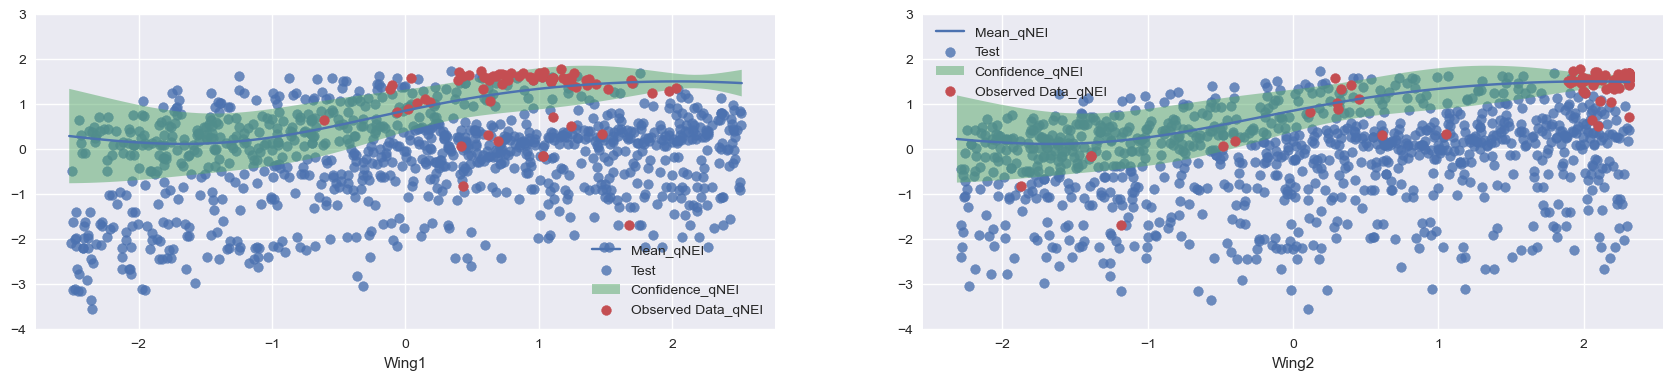

In [47]:
fig = plt.figure(figsize=(21, 9))

for alpha in range(2):#X_lofi.shape[1]):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        # Make predictions by feeding model through likelihood
        '''observed_pred = (gp_model(test_x ))    
        observed_pred_UCB = (gp_model_UCB(test_x )) 
        observed_pred_PI = (gp_model_PI(test_x )) 
        observed_pred_EI = (gp_model_EI(test_x )) 
        observed_pred_qEI = (gp_model_qEI(test_x )) '''
        observed_pred_qNEI = (gp_model_qNEI(test_x ))  
        # Initialize plot 
        ax = fig.add_subplot(2, 2, alpha+1)      
        ax.scatter(X_test[:,alpha].numpy(), Y_test[:,0].numpy(), alpha=0.8, label = 'Test')
         
        # Get upper and lower confidence bounds
        '''lower, upper = observed_pred.confidence_region() '''
        # Plot predictive means as blue line
        '''ax.plot(test_x.numpy(), observed_pred.mean.numpy(), label = 'Mean')    
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence') 
        ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi.numpy(), s=50,label = 'Observed Data')'''

        '''lower, upper = observed_pred_UCB.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_UCB.mean.numpy(), label = 'Mean_UCB')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_UCB')  
        ax.scatter(X_lofi_UCB[:,alpha].numpy(), Y_lofi_UCB.numpy(), s=50,label = 'Observed Data_UCB')'''

        '''lower, upper = observed_pred_PI.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_PI.mean.numpy(), label = 'Mean_PI')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_PI')  
        ax.scatter(X_lofi_PI[:,alpha].numpy(), Y_lofi_PI.numpy(), s=50,label = 'Observed Data_PI')'''

        '''lower, upper = observed_pred_EI.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_EI.mean.numpy(), label = 'Mean_EI')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_EI')  
        ax.scatter(X_lofi_EI[:,alpha].numpy(), Y_lofi_EI.numpy(), s=50,label = 'Observed Data_EI')'''
    
        '''lower, upper = observed_pred_qEI.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_qEI.mean.numpy(), label = 'Mean_qEI')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_qEI')  
        ax.scatter(X_lofi_qEI[:,alpha].numpy(), Y_lofi_qEI.numpy(), s=50,label = 'Observed Data_qEI')'''

        lower, upper = observed_pred_qNEI.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_qNEI.mean.numpy(), label = 'Mean_qNEI')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_qNEI')  
        ax.scatter(X_lofi_qNEI[:,alpha].numpy(), Y_lofi_qNEI[:,0].numpy(), s=50,label = 'Observed Data_qNEI')

        ax.set_ylim([-4,3])
        plt.xlabel(f"Wing{alpha+1}")
        ax.legend()
        
    
plt.show()
# ADD NON-PCA DATA (ORIGINAL DATA) PLOT

# Plotly

In [ ]:
import plotly.graph_objs as go
from ipywidgets import interact, widgets

In [53]:
def update_layout_of_graph(fig: go.Figure,title: str = 'Plot')->go.Figure:
    fig.update_layout(
        width=800,
        height=600,
        autosize=False,
        plot_bgcolor='rgba(0,0,0,0)',
        title=title,
        
    )
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                      xaxis_title = 'input values',
                      yaxis_title = 'output values',
                      legend=dict(orientation="h",
                                  yanchor="bottom",
                                  y=1.02,
                                  xanchor="right",
                                  x=1),
                      title={
                          'x': 0.5,
                          'xanchor': 'center'
                      })
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
    return fig

In [108]:
def uncertainty_area_scatter(
        visible: bool = True,
        x_lines: np.array = np.array([]),
        y_upper: np.array = np.array([]),
        y_lower: np.array = np.array([]),
        name: str = "mean plus/minus standard deviation",
        legend_group: str = 'acqf',
        showlegend: bool = False,
) -> go.Scatter:

    return go.Scatter(
        visible=visible,
        x=np.concatenate((x_lines, x_lines[::-1])),  # x, then x reversed
        # upper, then lower reversed
        y=np.concatenate((y_upper, y_lower[::-1])),
        fill='toself',
        fillcolor='rgba(189,195,199,0.5)',
        line=dict(color='rgba(200,200,200,0)'),
        hoverinfo="skip",
        name= name,
        legendgroup = legend_group,
        showlegend=showlegend,
    )

In [96]:
def line_scatter(
    visible: bool = True,
    x_lines: np.array = np.array([]),
    y_lines: np.array = np.array([]),
    name_line: str = 'Predicted function',
    legend_group: str = 'acqf',
    showlegend: bool = True,
) -> go.Scatter:
    # Adding the lines
    return go.Scatter(
        visible=visible,
        line=dict(color="blue", width=2),
        x=x_lines,
        y=y_lines,
        name=name_line,
        legendgroup = legend_group,
        showlegend= showlegend
    )

In [97]:
def test_scatter(
    visible: bool = True,
    x_dots: np.array = np.array([]),
    y_dots: np.array = np.array([]),
    name_dots: str = 'Test',
    showlegend: bool = True
) -> go.Scatter:
    # Adding the dots
    return go.Scatter(
        x=x_dots,
        visible=visible,
        y=y_dots,
        mode="markers",
        name=name_dots,
        marker=dict(color='green', size=7),
        showlegend=showlegend
    )

In [104]:
def dot_scatter(
    visible: bool = True,
    x_dots: np.array = np.array([]),
    y_dots: np.array = np.array([]),
    name_dots: str = 'Obs',
    legend_group: str = 'acqf',
    showlegend: bool = False
) -> go.Scatter:
    # Adding the dots
    return go.Scatter(
        x=x_dots,
        visible=visible,
        y=y_dots,
        mode="markers",
        legendgroup = legend_group,
        name=name_dots,
        marker=dict(color='red', size=7),
        showlegend=showlegend
    )

In [109]:
def plot_GPR(data_x, data_y, model, x, legend_group, visible=True) -> list:
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed = model(x)
        lower, upper = observed.confidence_region()
        data = []
        
        data.append(
            uncertainty_area_scatter(
                x_lines=x.numpy(),
                y_lower=lower.numpy(),
                y_upper=upper.numpy(),
                name=f"uncertainty",
                legend_group = legend_group,
                visible=visible))
        data.append(line_scatter(x_lines=x.numpy(), y_lines=observed.mean.numpy(), visible=visible, name_line =legend_group, legend_group = legend_group))
        data.append(dot_scatter(x_dots=data_x.numpy(), y_dots=data_y.numpy(), visible=visible, legend_group = legend_group))
        
    return data

In [ ]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=X_lofi.shape[-1], cols=Y_lofi.shape[-1])
for i in range(Y_lofi.shape[-1]):
    for alpha in range(X_lofi.shape[-1]):
        fig.add_trace( dot_scatter(x_dots=X_hifi[:,alpha].numpy(), y_dots=Y_hifi[:,i].numpy()), row=alpha+1, col=i+1 )
        fig.add_trace( test_scatter(x_dots=X_lofi_qNEI[:,alpha].numpy(), y_dots=Y_lofi_qNEI[:,i].numpy()), row=alpha+1, col=i+1 )
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [70]:
plot_data = plot_GPR(data_x=X_lofi_qNEI[:,1], data_y=Y_lofi_qNEI[:,0], 
                     x=test_x, model=gp_model_qNEI)
fig4 = go.Figure(data=plot_data)
fig4.add_traces
fig4 = update_layout_of_graph(fig=fig4,
                              title='GPR on Opt Points vs Test Points')

fig4.show()

In [123]:
plot = plot_GPR(data_x=X_lofi[:,1], data_y=Y_lofi[:,0], 
                     x=test_x, model=gp_model,legend_group="rand")
plot_UCB = plot_GPR(data_x=X_lofi_UCB[:,1], data_y=Y_lofi_UCB[:,0], 
                     x=test_x, model=gp_model_UCB,legend_group="UCB")
plot_PI = plot_GPR(data_x=X_lofi_PI[:,1], data_y=Y_lofi_PI[:,0], 
                     x=test_x, model=gp_model_EI,legend_group="PI")
plot_EI = plot_GPR(data_x=X_lofi_EI[:,1], data_y=Y_lofi_EI[:,0], 
                     x=test_x, model=gp_model_EI,legend_group="EI")
plot_qEI = plot_GPR(data_x=X_lofi_qEI[:,1], data_y=Y_lofi_qEI[:,0], 
                     x=test_x, model=gp_model_qEI,legend_group="qEI")
plot_qNEI = plot_GPR(data_x=X_lofi_qNEI[:,1], data_y=Y_lofi_qNEI[:,0],
                     x=test_x, model=gp_model_qNEI,legend_group="qNEI")
fig4 = go.Figure()

fig4.add_trace(go.Scatter(
    x=X_test[:,1],
    y=Y_test[:,0],
    legendgroup="test",  # this can be any string, not just "group"
    name="test",
    mode="markers",
    marker=dict(color="Green", size=7)
))

fig4.add_traces(data=plot )
fig4.add_traces(data=plot_UCB )
fig4.add_traces(data=plot_PI )
fig4.add_traces(data=plot_EI )
fig4.add_traces(data=plot_qEI )
fig4.add_traces(data=plot_qNEI)

fig4.update_layout(
        width=1500,
        height=800,
        autosize=False,
        plot_bgcolor='rgba(0,0,0,0)',
        title='GPR on Opt Points vs Test Points')

fig4.show()

In [131]:
str1 = 'carla'
str2 = 'sofotta'
str = "".join([str1,str2])
print(str)
str = str1+str2
print(str)

carlasofotta
carlasofotta
